## Overview

In this notebook, I've built a linear model and MLP and trained on the Weinstock2016 dataset. 

The data is from the Weinstock2016 dataset with ~200 subjects. Current set up is to collapse the 192x6 matrix and predict $y \in R^{24}$ given the previous values $x \in R^{192}$ where 192 is the number of glucose measurements and 6 is the features (year, month, day, hour, minute, glucose).

In [1]:
# load libraries 
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.weinstock2016 import *
from dataset import TSDataset
from conf import Conf

In [2]:
# loading the config file, setting the experiment name, and the seed for random pre-processing parts (like splitting)
cnf = Conf(conf_file_path='./conf/weinstock.yaml', seed=15, exp_name="Weinstock", log=False)

In [3]:
# call the data fromatter directly
data_formatter = WeinstockFormatter(cnf)

Dropped segments: 1012
Extracted segments: 1085


In [4]:
# we are going to pass our data formatter and the config file to the TSDataset class
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

Getting valid sampling locations.
# available segments=252901
Extracting 5000 samples out of 252901
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=474
Extracting all available segments.
Getting valid sampling locations.
# available segments=44660
Extracting 5000 samples out of 44660
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...


[ 0.05219857 -0.0880001   1.103775   -1.6791736   1.0141653   0.39664298]


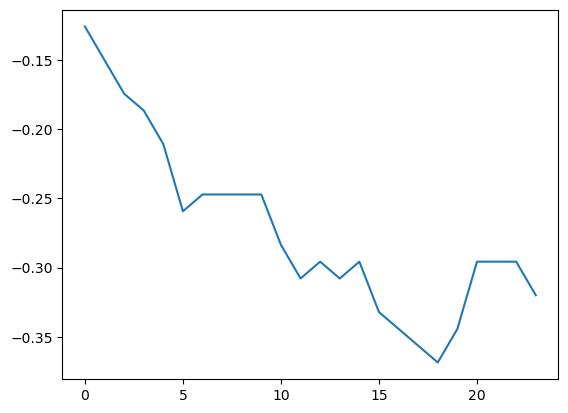

[ 0.05219857 -0.0880001  -1.2119602  -0.24402826 -0.72403276  0.20230493]


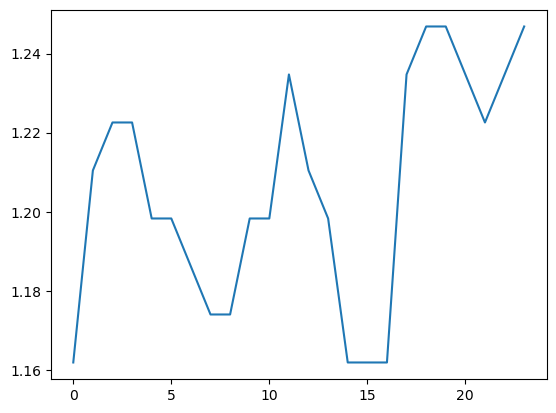

[ 0.05219857 -0.0880001  -1.0338267  -1.3921446  -0.14463343 -1.1459153 ]


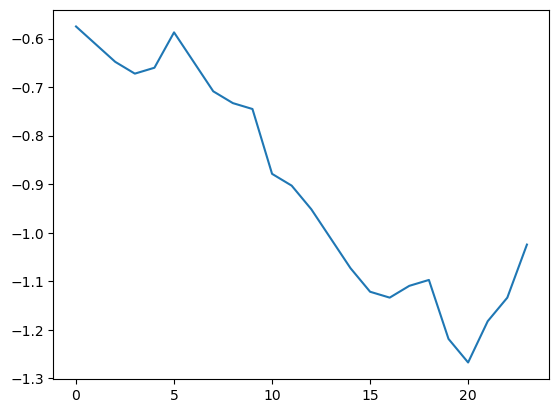

[ 0.05219857 -0.0880001  -1.0338267  -1.5356591  -1.5931318  -0.30783245]


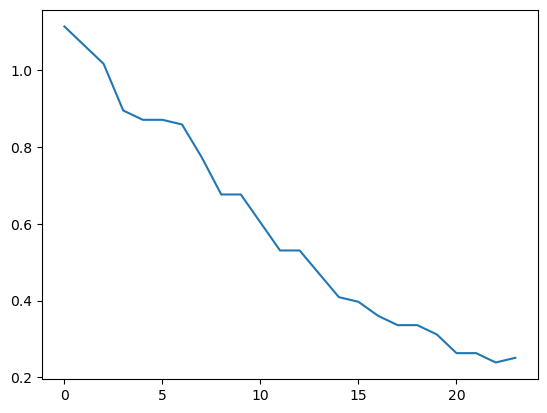

[ 0.05219857 -0.0880001   0.21310763  0.61705893 -0.43433312 -0.49002436]


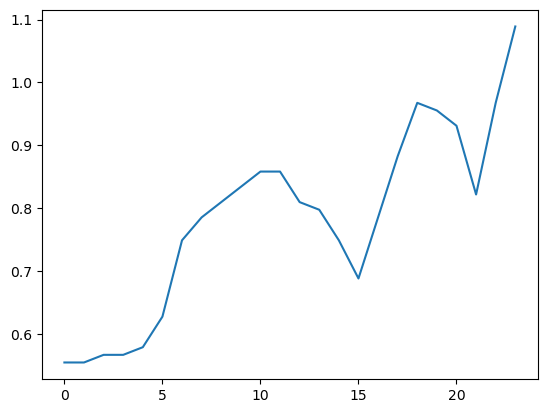

In [5]:
# plot inputs and outputs to check for issues
for i in range(5):
    x = test_dataset[i]['inputs']
    print(x[0, :])
    y = test_dataset[i]['outputs']

    # plt.plot(x[:, 5])
    plt.plot(y)
    plt.show()

In [6]:
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

This is just a linear regression model. The first linear layer (linear_collapse) takes the X matrix from 192x6 to 192x1. After squeezing to a $vector \in R^{192}$, it is passed to the actual linear layer (linear) going from $R^{192}$ to $R^{24}$.

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [8]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(100):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: 0.3347
Epoch [1/100], Val Loss: 1.2392
Epoch [2/100], Loss: 0.8130
Epoch [2/100], Val Loss: 1.2232
Epoch [3/100], Loss: 1.6202
Epoch [3/100], Val Loss: 1.2130
Epoch [4/100], Loss: 0.7004
Epoch [4/100], Val Loss: 1.2059
Epoch [5/100], Loss: 1.2036
Epoch [5/100], Val Loss: 1.2006
Epoch [6/100], Loss: 0.7346
Epoch [6/100], Val Loss: 1.1965
Epoch [7/100], Loss: 1.2435
Epoch [7/100], Val Loss: 1.1932
Epoch [8/100], Loss: 0.5654
Epoch [8/100], Val Loss: 1.1902
Epoch [9/100], Loss: 0.8225
Epoch [9/100], Val Loss: 1.1875
Epoch [10/100], Loss: 0.2261
Epoch [10/100], Val Loss: 1.1845
Epoch [11/100], Loss: 0.3592
Epoch [11/100], Val Loss: 1.1811
Epoch [12/100], Loss: 0.4421
Epoch [12/100], Val Loss: 1.1769
Epoch [13/100], Loss: 0.7375
Epoch [13/100], Val Loss: 1.1713
Epoch [14/100], Loss: 0.2523
Epoch [14/100], Val Loss: 1.1638
Epoch [15/100], Loss: 0.5337
Epoch [15/100], Val Loss: 1.1531
Epoch [16/100], Loss: 1.4532
Epoch [16/100], Val Loss: 1.1377
Epoch [17/100], Loss: 0.81

<All keys matched successfully>

In [9]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.1498


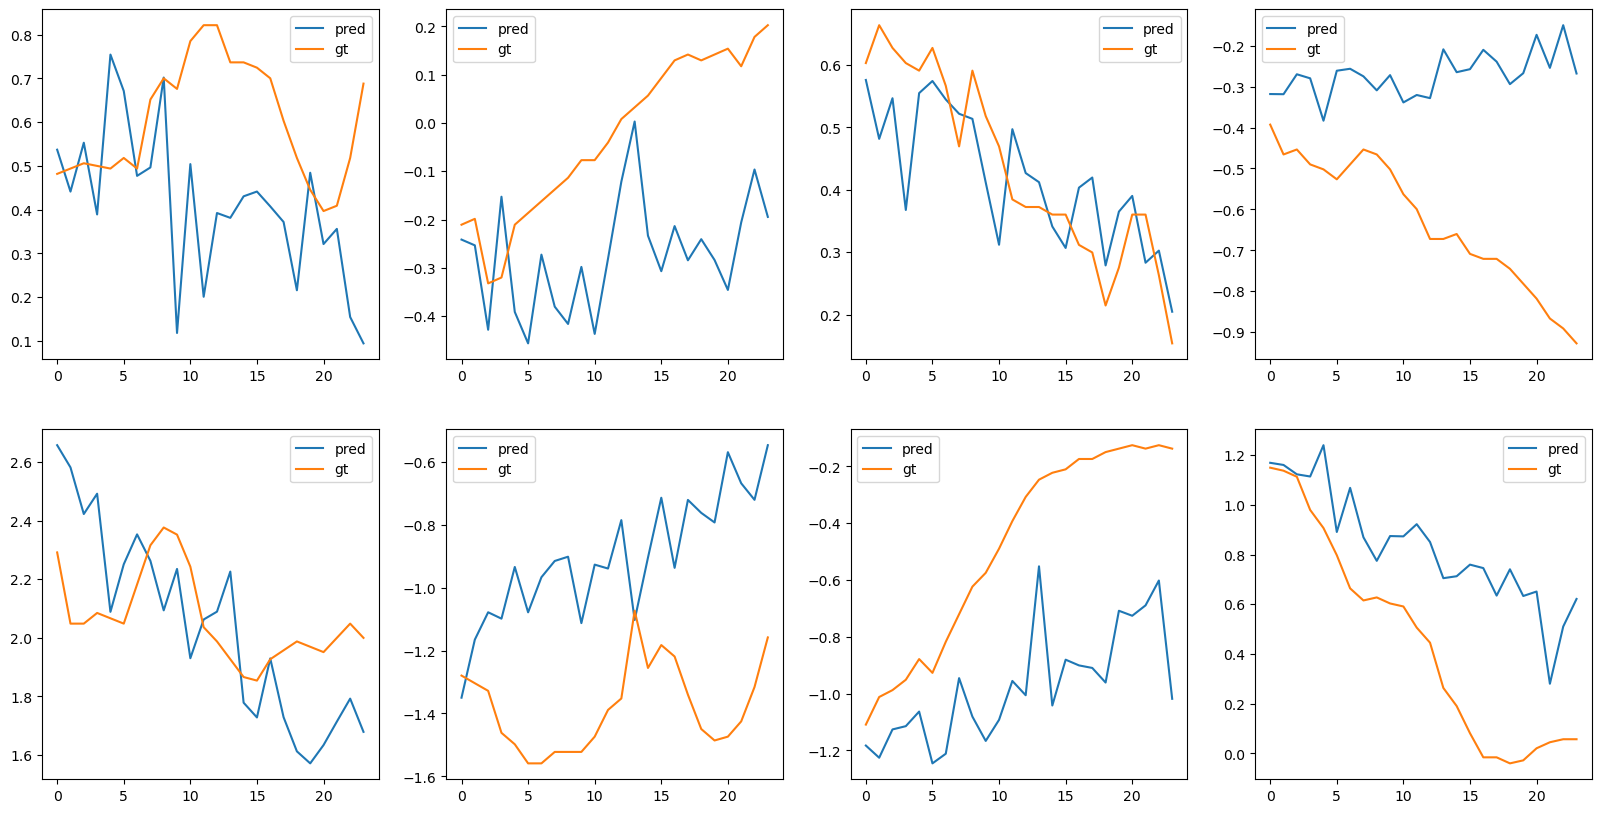

In [10]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## MLP

This is an MLP involving one non-linear layer.

In [11]:
# define model
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 24)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(torch.squeeze(self.linear_collapse(x)))))
        return y_pred


In [12]:
# train model
best_loss = 1e10000
model = MLP(36)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(100):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_mlp.pth')
# load best model
model.load_state_dict(torch.load('best_model_mlp.pth'))

Epoch [1/100], Loss: 0.4709
Epoch [1/100], Val Loss: 1.1624
Epoch [2/100], Loss: 1.0836
Epoch [2/100], Val Loss: 1.1494
Epoch [3/100], Loss: 0.4608
Epoch [3/100], Val Loss: 1.1359
Epoch [4/100], Loss: 0.6171
Epoch [4/100], Val Loss: 1.1223
Epoch [5/100], Loss: 1.5855
Epoch [5/100], Val Loss: 1.1074
Epoch [6/100], Loss: 1.0623
Epoch [6/100], Val Loss: 1.0906
Epoch [7/100], Loss: 1.0476
Epoch [7/100], Val Loss: 1.0714
Epoch [8/100], Loss: 0.3081
Epoch [8/100], Val Loss: 1.0495
Epoch [9/100], Loss: 0.4633
Epoch [9/100], Val Loss: 1.0249
Epoch [10/100], Loss: 0.7720
Epoch [10/100], Val Loss: 0.9968
Epoch [11/100], Loss: 0.6366
Epoch [11/100], Val Loss: 0.9652
Epoch [12/100], Loss: 1.4949
Epoch [12/100], Val Loss: 0.9296
Epoch [13/100], Loss: 1.6885
Epoch [13/100], Val Loss: 0.8906
Epoch [14/100], Loss: 0.8258
Epoch [14/100], Val Loss: 0.8501
Epoch [15/100], Loss: 1.1613
Epoch [15/100], Val Loss: 0.8087
Epoch [16/100], Loss: 0.4337
Epoch [16/100], Val Loss: 0.7677
Epoch [17/100], Loss: 0.51

<All keys matched successfully>

In [13]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.1655


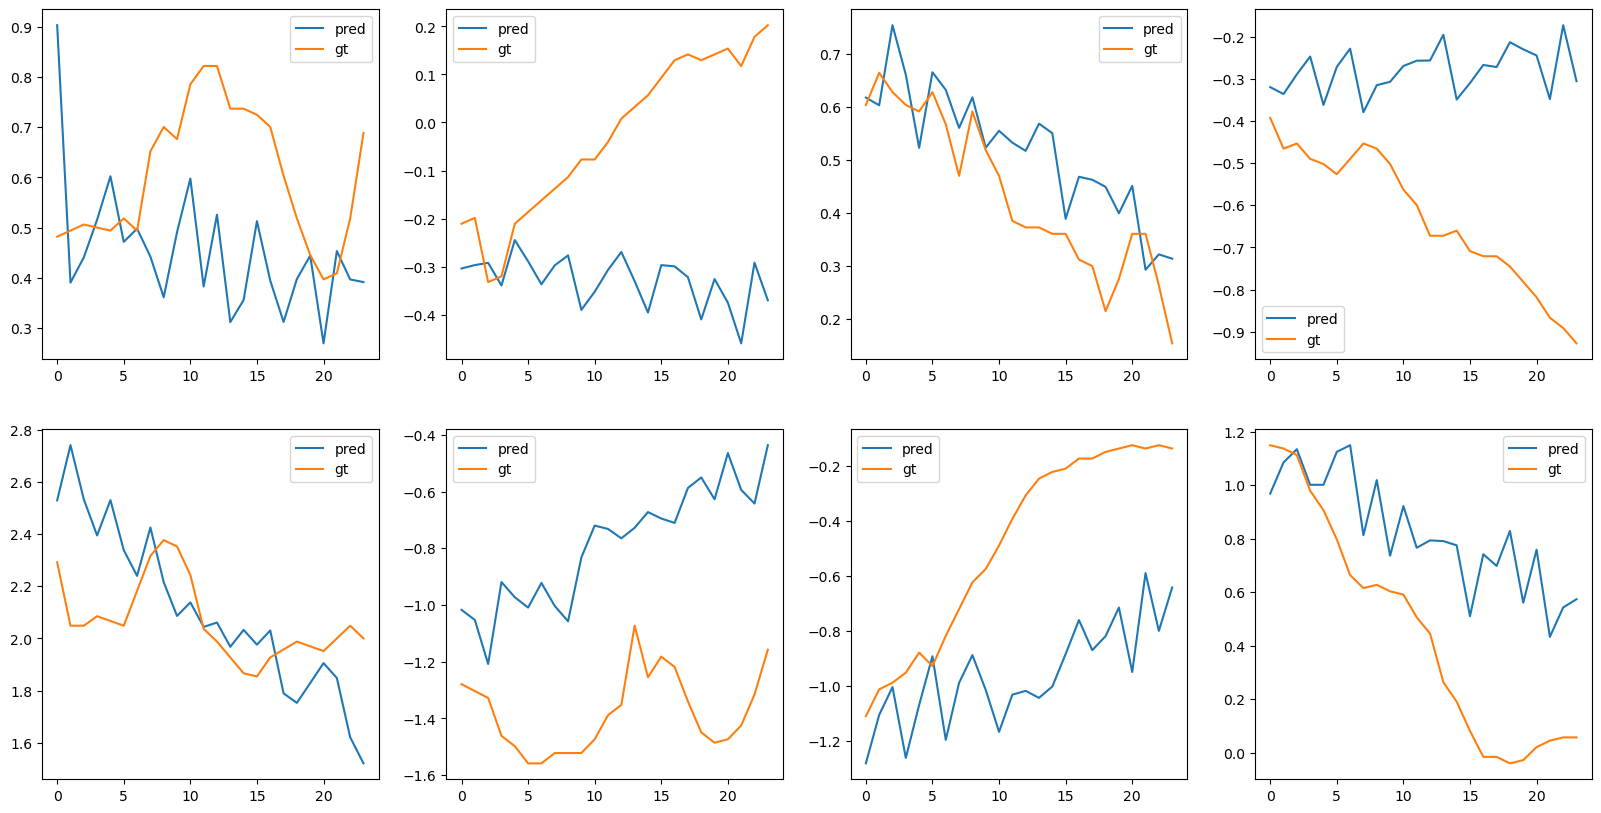

In [14]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()